Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним
, какой шрифт лучше.

## План:
1. Подготовка к анализу 
2. Анализ данных:
  - Сколько всего событий в логе?;
  - Узнаем, сколько всего пользователей в логе;
  - Посмотрим, сколько в среднем событий приходится на пользователя;
  - Найдем максимаьую и минимальную датую Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые. Выясним, данными за какой период времени располагаем на самом деле?;
  - Посчитаем, много ли событий и пользователей вы потеряли, отбросив старые данные;
  - Убедимся, что унас остались пользователи всех трех групп.
3. Изучим воронку событий:
  - Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте;
  - Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие;
  - Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?;
  - По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем);
  - На каком шаге теряем больше всего пользователей?;
  - Какая доля пользователей доходит от первого события до оплаты?
4. Изучим результаты эксперимента:
  - Сколько пользователей в каждой экспериментальной группе?;
  - Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247;выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?;
  - Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой;
  - Посчитаем, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math as mth
from scipy import stats as st

# 1. Подготовка к анализу


In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
#246 и 247 — контрольные группы, а 248 — экспериментальная.
df.set_axis(['event', 'uid', 'timestamp', 'group_id'], axis = 1, inplace = True)


Приведем дату и время в читаемый вид:

In [5]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [6]:
df['date'] = df['datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])
df = df.drop(['timestamp'], axis = 1)
df

,event,uid,group_id,datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:58,2019-08-07


Проверим пропуски:

In [7]:
df.isna().sum()

event       0
uid         0
group_id    0
datetime    0
date        0
dtype: int64

Пропусков нет


# 2. Анализ данных

## Сколько всего событий в логе?

In [8]:
eve = df['event'].count()
eve

244126

Всего в логе 244126 событий

## Узнаем, сколько всего пользователей в логе

In [9]:
uniq = df['uid'].nunique()
uniq

7551

Всего получается 7551 уникальный пользователь в логе

## Посмотрим, сколько в среднем событий приходится на пользователя

In [10]:
mean_event = eve / uniq
mean_event

32.33028737915508

В среднем на пользователя приходится 32 события

## Найдем максимаьую и минимальную дату. Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые. Выясним, данными за какой период времени располагаем на самом деле?

In [11]:
df['date'].min()

Timestamp('2019-07-25 00:00:00')

Мнимальная дата  - 25 июля 2019 года

In [12]:
df['date'].max()

Timestamp('2019-08-07 00:00:00')

Максимальная дата - 7 августа 2019 года

In [13]:
time_event = df.groupby('date').agg({'event' : 'count'}).reset_index()
time_event

,date,event
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,413
6,2019-07-31,2031
7,2019-08-01,36229
8,2019-08-02,35606
9,2019-08-03,33351


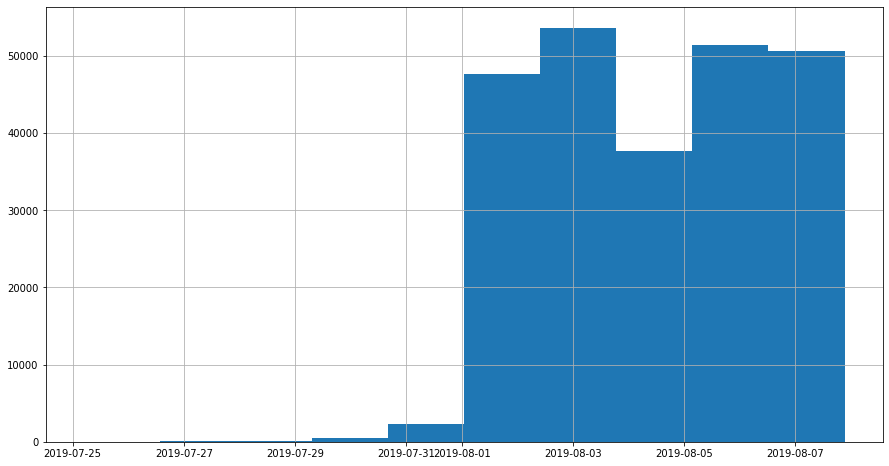

In [14]:
plt.figure(figsize = (15, 8))
df['datetime'].hist()


Хотя формально у нас данные с 25 июля, но реальные цифры начинают появляться только 1 августа

In [15]:
df1 = df.query('date > "2019-07-31" and date <= "2019-08-07"')
df1

,event,uid,group_id,datetime,date
2828,Tutorial,3737462046622621720,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:58,2019-08-07


Мы отсекли все данные до  августа

## Посчитаем, много ли событий и пользователей вы потеряли, отбросив старые данные

In [16]:
len(df) - len(df1)

2828

In [17]:
df['uid'].nunique() - df1['uid'].nunique()

17

In [18]:
df['event'].count() - df1['event'].count()

2828

Мы лишились 2828 строк, это совсем мало в масштабах наших данных. Потеряли 17 пользоватлей и 2828 событий.

## Убедимся, что унас остались пользователи всех трех групп

In [19]:
df1['group_id'].unique()

array([246, 247, 248])

Да, у нас действительно остались все группы пользоваталей

# 3. Изучим воронку событий

## Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [20]:
df1['event'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

Самое популярное событие это главная страница - ничего удивительного. А вот туториал почти никто не смотрел

## Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [21]:
event = df1.groupby('event').agg({'uid' : 'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
event

,event,uid
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [22]:
df1['uid'].nunique()

7534

In [23]:
event['prt'] = event['uid'] / 7534 * 100
event['prt'] = event['prt'].apply(np.ceil)
event

,event,uid,prt
1,MainScreenAppear,7419,99.0
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,12.0


Всего дошло по покупки **47%** пользователей. Интересно, что до страницы с товаром добралось **61%**

## Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

По идее, последовательность должна быть следующая: туториал -> главная страница -> страница с товаром/услугой -> корзина с товаром -> экран оплаты.

Но мы видим, что очень многие просто пропускают туториал, поэтому первой точкой скорее будет главная страница. Поэтому предлагаю от Tutorial избавиться

In [24]:
event = event.query('event not in "Tutorial"')

In [25]:
event

,event,uid,prt
1,MainScreenAppear,7419,99.0
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0


## По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [26]:
event['part'] = event['uid']
event['part'] = event['part'].shift(1, fill_value=0)
event

,event,uid,prt,part
1,MainScreenAppear,7419,99.0,0
2,OffersScreenAppear,4593,61.0,7419
0,CartScreenAppear,3734,50.0,4593
3,PaymentScreenSuccessful,3539,47.0,3734


In [27]:
event['percent'] = event['uid'] / event['part'] * 100
event['percent'] = event['percent'].apply(np.ceil)
event = event.drop(['part'], axis = 1)
event

,event,uid,prt,percent
1,MainScreenAppear,7419,99.0,inf
2,OffersScreenAppear,4593,61.0,62.0
0,CartScreenAppear,3734,50.0,82.0
3,PaymentScreenSuccessful,3539,47.0,95.0


## На каком шаге теряем больше всего пользователей?

In [28]:
event

,event,uid,prt,percent
1,MainScreenAppear,7419,99.0,inf
2,OffersScreenAppear,4593,61.0,62.0
0,CartScreenAppear,3734,50.0,82.0
3,PaymentScreenSuccessful,3539,47.0,95.0


Больше всего пользователей теряем при переходе с главной старницы на старницу товара - добираются лишь **62%** пользователей

## Какая доля пользователей доходит от первого события до оплаты?

In [29]:
event

,event,uid,prt,percent
1,MainScreenAppear,7419,99.0,inf
2,OffersScreenAppear,4593,61.0,62.0
0,CartScreenAppear,3734,50.0,82.0
3,PaymentScreenSuccessful,3539,47.0,95.0


От первого события до оплаты доходит **47%** пользователей

# Изучим результаты эксперимента:

## Сколько пользователей в каждой экспериментальной группе?

In [30]:
df1['group_id'].value_counts()


248    84726
246    79425
247    77147
Name: group_id, dtype: int64

In [31]:
event_246 = df1.query('group_id == 246')
ev_246 = event_246['uid'].nunique()
ev_246

2484

In [32]:
event_247 = df1.query('group_id == 247')
ev_247 = event_247['uid'].nunique()
ev_247

2513

In [33]:
event_248 = df1.query('group_id == 248')
ev_248 = event_248['uid'].nunique()
ev_248

2537

246 и 247 — контрольные группы, а 248 — экспериментальная. В 248 - **2537** человек; в 247 - **2513** человек; в 246 - **2484** человек

## Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [34]:
event_246 = event_246.groupby('event').agg({'uid' : 'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
event_246 = event_246.query('event not in "Tutorial"')

In [35]:
event_246['part246'] = event_246['uid'] / 2484 * 100
event_246['part246'] = event_246['part246'].apply(np.ceil)
event_246

,event,uid,part246
1,MainScreenAppear,2450,99.0
2,OffersScreenAppear,1542,63.0
0,CartScreenAppear,1266,51.0
3,PaymentScreenSuccessful,1200,49.0


In [36]:
event_247 = event_247.groupby('event').agg({'uid' : 'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
event_247 = event_247.query('event not in "Tutorial"')


In [37]:
event_247['part247'] = event_247['uid'] / 2513 * 100
event_247['part247'] = event_247['part247'].apply(np.ceil)
event_247

,event,uid,part247
1,MainScreenAppear,2476,99.0
2,OffersScreenAppear,1520,61.0
0,CartScreenAppear,1238,50.0
3,PaymentScreenSuccessful,1158,47.0


Самое популярное событие в обеих группах это заход на главную страницу, но если не брать в рассчет это, то самый популярный - переход на страницу товара

In [38]:
groups = event_246.merge(event_247, on = 'event')
groups.set_axis(['event', 'uid_246', 'part_246', 'uid_247', 'part_247'], axis = 1)
groups

,event,uid_246,part_246,uid_247,part_247
0,MainScreenAppear,2450,99.0,2476,99.0
1,OffersScreenAppear,1542,63.0,1520,61.0
2,CartScreenAppear,1266,51.0,1238,50.0
3,PaymentScreenSuccessful,1200,49.0,1158,47.0


Узнаем, есть ли различия между группами статистически достоверными:

In [39]:
def ztest(row):
    alpha = .05
    successes = np.array([row['uid_246'], row['uid_247']])
    trials = np.array([2484, 2513])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Мы видим, что оснований считать доли разными нет. Разбиение на группы выполнено **корректно**.

## Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой

In [40]:
event_248 = event_248.groupby('event').agg({'uid' : 'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)
event_248 = event_248.query('event not in "Tutorial"')
event_248

,event,uid
1,MainScreenAppear,2493
2,OffersScreenAppear,1531
0,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181


In [41]:
event_248['part248'] = event_248['uid'] / 2537 * 100
event_248['part248'] = event_248['part248'].apply(np.ceil)
event_248.set_axis(['event', 'uid_248', 'part_248'], axis = 1)
event_248

,event,uid_248,part_248
1,MainScreenAppear,2493,99.0
2,OffersScreenAppear,1531,61.0
0,CartScreenAppear,1230,49.0
3,PaymentScreenSuccessful,1181,47.0


In [42]:
groups = groups.merge(event_248, on = 'event')
groups

,event,uid_246,part_246,uid_247,part_247,uid_248,part_248
0,MainScreenAppear,2450,99.0,2476,99.0,2493,99.0
1,OffersScreenAppear,1542,63.0,1520,61.0,1531,61.0
2,CartScreenAppear,1266,51.0,1238,50.0,1230,49.0
3,PaymentScreenSuccessful,1200,49.0,1158,47.0,1181,47.0


Сравним результат каждой из контрольных групп (246, 247) с экспериментальной группой(248):

In [43]:
def ztest(row):
    alpha = .05
    successes = np.array([row['uid_246'], row['uid_248']])
    trials = np.array([2484, 2537])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Разницы в долях между первой контрольной группой и экспериментальной.

Теперь со второй попробуем:

In [44]:
def ztest(row):
    alpha = .05
    successes = np.array([row['uid_247'], row['uid_248']])
    trials = np.array([2513, 2537])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Теперь объединим контрольные группы и сравним с экспериментальной:

In [45]:
groups['united'] = groups['uid_246'] + groups['uid_247']
groups

,event,uid_246,part_246,uid_247,part_247,uid_248,part_248,united
0,MainScreenAppear,2450,99.0,2476,99.0,2493,99.0,4926
1,OffersScreenAppear,1542,63.0,1520,61.0,1531,61.0,3062
2,CartScreenAppear,1266,51.0,1238,50.0,1230,49.0,2504
3,PaymentScreenSuccessful,1200,49.0,1158,47.0,1181,47.0,2358


In [46]:
def ztest(row):
    alpha = .05
    successes = np.array([row['united'], row['uid_248']])
    trials = np.array([4997, 2493])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 2.2308710434515433e-09
Отвергаем гипотезу: между долями есть разница
p-значение: 0.9098670209102104
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.5289431225593517
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.8803090545674654
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Не одинаковая доля тех, кто попадает на главную страницу объясняется серьезным различием в численности групп. Во всех остальных событиях разницы в долях нет

 Проведем эксперимент с уровнем статистической зачимости 0.1:

In [47]:
def ztest(row):
    alpha = .01
    successes = np.array([row['uid_246'], row['uid_247']])
    trials = np.array([2484, 2513])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Тут ничего не поменялось

In [48]:
def ztest(row):
    alpha = .01
    successes = np.array([row['uid_246'], row['uid_248']])
    trials = np.array([2484, 2537])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

In [49]:
def ztest(row):
    alpha = .01
    successes = np.array([row['uid_247'], row['uid_248']])
    trials = np.array([2513, 2537])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

In [50]:
def ztest(row):
    alpha = .01
    successes = np.array([row['united'], row['uid_248']])
    trials = np.array([4997, 2537])

    p1 = successes[0] / trials[0]

    p2 = successes[1] / trials[1]

    p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2
    z_value = difference / mth.sqrt(p_comb * (1 - p_comb) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение:', p_value)


    if(p_value < alpha):
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
groups.apply(ztest, axis = 1)

p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


0    None
1    None
2    None
3    None
dtype: object

Все тесты показали, что разницы нет особой разницы между контрольными группами и экспериментальными группамию Результаты не изменились, когда мы поробовали повторить эксперимент с уровнем статистической зачимости 0.1.

Один из главных выводов: основной отток ползователей идет после посещения ими главной страницы. Эта проблема характерна и для контрольных и для экспериментальной группы. Но при этом если уж клиент кладе товар в крзину, то почти вскгда его покупает в итоге. Это говорит о том, что проблем с оплатой, с экраном оплаты нет. Но нужно обратить внимание на главную страницу. Скорее всего ее нужно будет переделать. Или при первом заходе показывать клиенту небольшой туториал(сами по себе туториалы не совсем популярны). Но лучше сделать интерфейс более интуативным.